Source: https://www.tensorflow.org/tutorials/

In [47]:
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import os, random, time, json

TensorFlow version: 2.10.1


In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 2s 0us/step


<class 'numpy.ndarray'>
(60000, 28, 28)


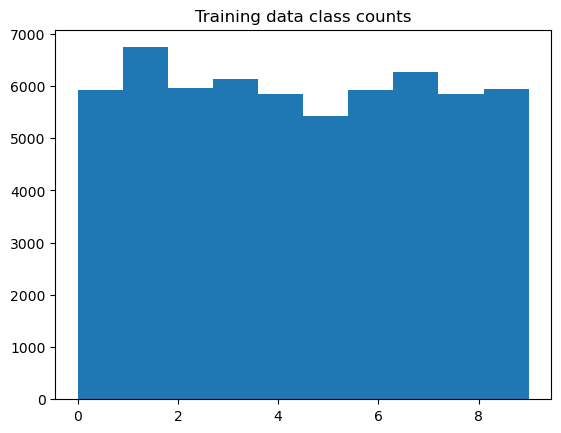

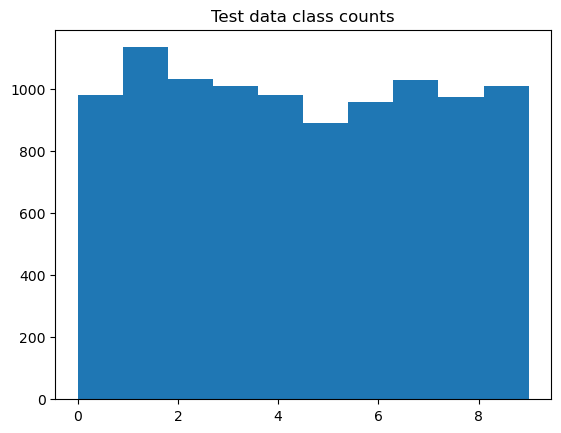

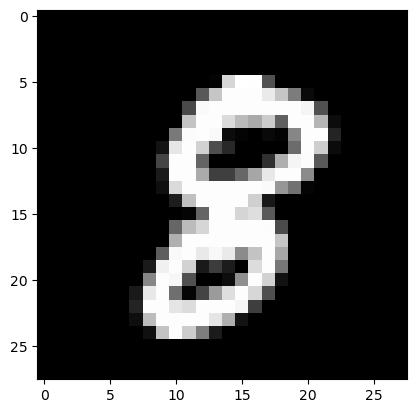

In [11]:
print (type(x_train))
print (x_train.shape)

# plot class counts for training data and test data
plt.hist(y_train, bins=10)
plt.title("Training data class counts")
plt.show()

plt.hist(y_test, bins=10)
plt.title("Test data class counts")
plt.show()

# look at a random images from training data
plt.imshow(x_train[random.randint(0, x_train.shape[0])], cmap='gray')

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [13]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.00192577, -0.34750742,  0.2726571 ,  0.5500859 , -0.2775718 ,
         0.06751752, -0.09556411,  0.8386718 ,  0.5240142 ,  0.8126612 ]],
      dtype=float32)

In [14]:
tf.nn.softmax(predictions).numpy()

array([[0.07262068, 0.05140154, 0.09556748, 0.12612349, 0.05512502,
        0.07784293, 0.06612927, 0.16831669, 0.12287772, 0.16399513]],
      dtype=float32)

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [19]:
print ("Actual label: ", y_train[:1])

prob_predictions = tf.nn.softmax(predictions).numpy()
print ("Predicted probabilitys: ", prob_predictions)
prob_of_actual_label = prob_predictions[0][y_train[0]]

tf_loss = loss_fn(y_train[:1], predictions).numpy()

# above loss should be same as -log(predicted probability of actual label)
np_loss = -np.log(prob_of_actual_label)
print ("TensorFlow loss: ", tf_loss)
print ("Numpy loss: ", np_loss)

assert round(tf_loss, 5) == round(np_loss, 5)
"""
Entropy definition: H(p) = - sum(p(x) * log(p(x)))  
it is the lowest number of expected bits needed to be sent to relay the information about which event has occurred

Probability 
Sigma: sample space of discrete events: {x1, x2, x3, ... xn}
Event space: power set of Sigma: { {}, {x1}, {x2}, {x3}, ... {xn}, {x1, x2}, {x1, x3}, ... {x1, x2, x3, ... xn} }
Probability measure: P: Event space -> [0, 1]
P({}) = 0, P(Sigma) = 1
P({x1}) = p1, P({x2}) = p2, ... P({xn}) = pn

Now, say you are an astraunaut who is about to go on a mission to Mars and need to be 
aware of uncertain / probabilistic events from earth to make decisions. Assume possible events are {x1, x2, x3, ... xn}
from the above distribution. Bandwidth is limited and expensive between earth and Mars so you want to send the least number of bits
(in expectation) to relay the information about which event has occurred during the mission.

What encoding do you use to send the information about the event? And what is the lower bound on the bits you need to send?

H(p) is the minimum number of bits you need to send to relay the information about the event that has occurred.
And the encoding you use has -log_2(p(x)) bits allocated for each event x in Sigma.

Example: event space is {heads, tails}
Case-1: p(heads) = 0. Then H(p) = - (0 * log_2(0) + 1 * log_2(1)) = 0, i.e., no need to send anything as the astronaut already knows the event is tails
Note: 0 * log_2(0) is the limit of x * log_2(x) as x approaches 0 from the right. It is defined to be 0.
Case-2: p(heads) = 0.5. Then H(p) = - (0.5 * log_2(0.5) + 0.5 * log_2(0.5)) = 1, i.e., send 1 bit to relay the information about the event. 
Send either 0 or 1 depending on the event that has occurred. Not possible to do any better than this.
Case-3: p(heads) = 3/4. Then H(p) = - (3/4 * log_2(3/4) + 1/4 * log_2(1/4)) = 0.31 + 0.5 = 0.81 bits.
This says that no matter how cleverly you design the encoding, you need to send at least 0.81 bits per event to relay the information. This is what Shannon proved in his paper.
We can do this in 1 bit if we use the following encoding: heads -> 0, tails -> 1. But, the expected number of bits sent is 0.81 bits.
So lets try to do better using Huffman encoding that is provably very close to the entropy.
H(p) <= L < H(p) + 1, where L is the expected number of bits sent using Huffman encoding.
https://math.mit.edu/~shor/18.310/huffman.pdf

You'll be sending a long list of events instead of just 1 time. So, for analyzing this, assume you need to send the following string of events:
e1, e2, e3, ... en. Where each ei is independently drawn from the distribution p(x).
Follow this encoding to be more efficient:
    - HH (probability 9/16)
    - HT (probability 3/16)
    - TH (probability 3/16)
    - TT (probability 1/16)
Huffman coding: Merge the least probable events to form a new event and repeat the process until you have only 2 events left.
Get this binary tree: {{{{TT}, {TH}}, {HT}}, {HH}} implying this coding:
HH -> 0, HT -> 10, TH -> 110, TT -> 111

Expected number of bits sent per event = (9/16 * 1 + 3/16 * 2 + 3/16 * 3 + 1/16 * 3) / 2 = 0.84 bits (close to 0.81 bits and less than 1 bit)

Cross entropy: H(p, q) = - sum(p(x) * log(q(x)))
It is the expected number of bits sent using encoding optimized for distribution q when the true distribution is p.
The true distribution "p" is usually unknown and extremely hard to model. So, we build models in machine learning to approximate p using q.
Now, cross entropy is a metric that measures how well did we do in modelling the true distribution p using q.
It says that if you used your dopey model q to encode the events, you would have sent H(p, q) bits per event on average where as the best you could have done is H(p) bits.
Mistakes in modelling the true distribution p using q is costing you precious and limited bandwidth on your mission to Mars.

KL divergence: D_KL(p || q) = H(p, q) - H(p) 
It is the extra number of bits sent per event on average due to using model q instead of the true distribution p. It is zero if q = p.

Why use cross entropy as loss function? 
Some answers: https://datascience.stackexchange.com/questions/53400/what-makes-binary-cross-entropy-a-better-choice-for-binary-classification-than-o

minimizing cross entropy is same as obtaining maximum likelihood estimate of the parameters of the model
theta_mle = argmax_theta P(data | theta) = argmin_x exp(sum -log(q(x|theta)))
therefore loss function term is -log(q(x|theta)) which is the cross entropy term

we may want to tweak it sometimes. Example, say precision is more important than recall in a binary classification problem. 
Then, we may want to give higher weights to false positives than false negatives.
"""

_ = 1

Actual label:  [5]
Predicted probabilitys:  [[0.07262068 0.05140154 0.09556748 0.12612349 0.05512502 0.07784293
  0.06612927 0.16831669 0.12287772 0.16399513]]
TensorFlow loss:  2.5530624
Numpy loss:  2.5530622


In [20]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [21]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2910 - accuracy: 0.9158
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1431 - accuracy: 0.9575
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1049 - accuracy: 0.9686
Epoch 4/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0862 - accuracy: 0.9732
Epoch 5/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0748 - accuracy: 0.9768


In [22]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 2s - loss: 0.0755 - accuracy: 0.9759 - 2s/epoch - 6ms/step


[0.07552769780158997, 0.9758999943733215]

In [23]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [24]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[6.8235792e-08, 1.0434038e-09, 1.3798266e-05, 5.5592117e-04,
        1.5909567e-11, 6.1253121e-07, 6.8202496e-15, 9.9938691e-01,
        1.8077048e-06, 4.0901552e-05],
       [6.1293920e-10, 2.3165633e-04, 9.9952888e-01, 2.3655067e-04,
        8.3078218e-14, 1.8867034e-06, 7.2720510e-09, 3.2682450e-12,
        1.1079442e-06, 1.3533005e-13],
       [3.0223415e-08, 9.9760604e-01, 8.5805132e-06, 1.7801216e-06,
        1.6908856e-05, 3.6070246e-06, 8.0649370e-06, 2.2532258e-03,
        9.8942161e-05, 2.8103138e-06],
       [9.9995589e-01, 4.2921652e-10, 2.3118699e-05, 1.9298571e-07,
        5.4974536e-10, 1.3704378e-05, 1.6973619e-06, 4.6338841e-06,
        8.9343104e-08, 6.0141156e-07],
       [2.7887805e-05, 3.9204453e-09, 9.6674135e-05, 9.8730550e-07,
        9.9237204e-01, 1.0149863e-06, 2.9464212e-05, 5.9210572e-05,
        3.3387743e-05, 7.3793428e-03]], dtype=float32)>

Actual label:  1
Predicted probabilities:  [[2.19381588e-12 9.99967813e-01 8.55914895e-09 1.90653714e-06
  7.30202419e-06 1.10785855e-07 9.36091624e-07 2.02922138e-06
  1.97959907e-05 9.04501007e-08]]
Predicted label:  1  with probability:  0.9999678


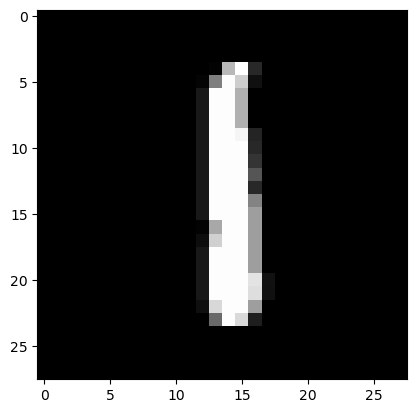

Actual label:  0
Predicted probabilities:  [[9.9992859e-01 2.6465347e-10 2.1333932e-07 4.5666969e-08 1.6710740e-12
  4.6227382e-05 1.0445202e-05 1.4488166e-05 6.0430105e-10 2.2180972e-10]]
Predicted label:  0  with probability:  0.9999286


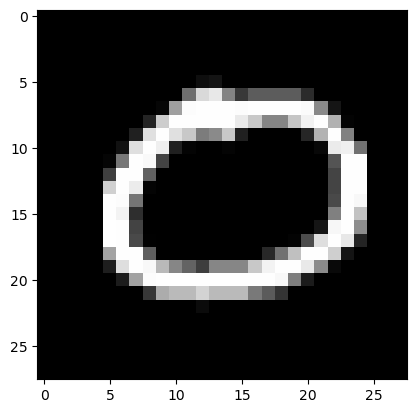

Actual label:  8
Predicted probabilities:  [[4.4427175e-06 1.4490800e-03 1.6169193e-05 5.3875858e-04 4.6312507e-05
  2.4699402e-04 1.6670086e-03 8.6273849e-06 9.9600369e-01 1.8838804e-05]]
Predicted label:  8  with probability:  0.9960037


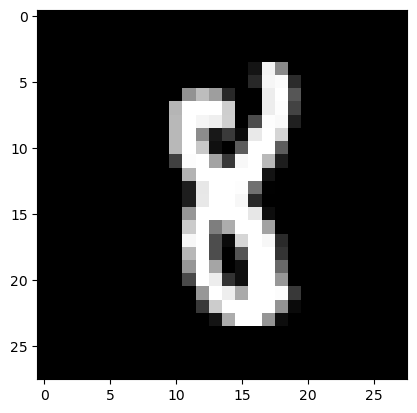

Actual label:  2
Predicted probabilities:  [[1.5326596e-03 7.2165342e-08 9.7582883e-01 1.1942986e-03 3.2455262e-12
  2.9105006e-06 9.2157539e-11 2.1414446e-02 2.5900126e-05 8.8761198e-07]]
Predicted label:  2  with probability:  0.9758288


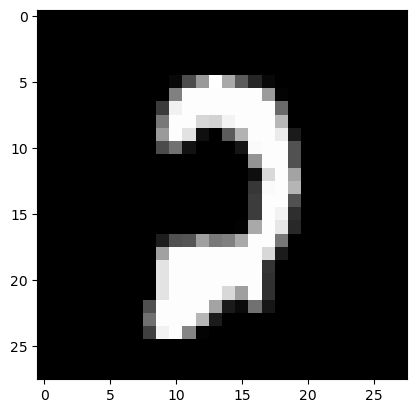

Actual label:  6
Predicted probabilities:  [[1.1819049e-09 7.4957562e-10 2.5375138e-07 1.9499296e-09 9.6991710e-07
  3.7603209e-10 9.9999881e-01 3.1488445e-09 8.1070251e-10 7.4607907e-15]]
Predicted label:  6  with probability:  0.9999988


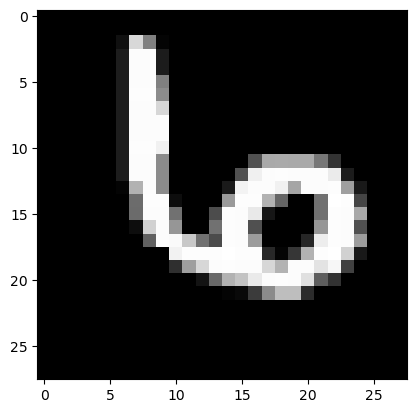

In [36]:
# see predictions on randomly picked samples
for _ in range(5):
    idx = random.randint(0, x_test.shape[0])
    data = x_test[idx]
    print ("Actual label: ", y_test[idx])
    predictions = probability_model(data.reshape(1, 28, 28)).numpy()
    print ("Predicted probabilities: ", predictions)
    print ("Predicted label: ", np.argmax(predictions), " with probability: ", np.max(predictions))
    plt.imshow(data, cmap='gray')
    plt.show()

Number of mistakes:  241
Number of correct predictions:  9759


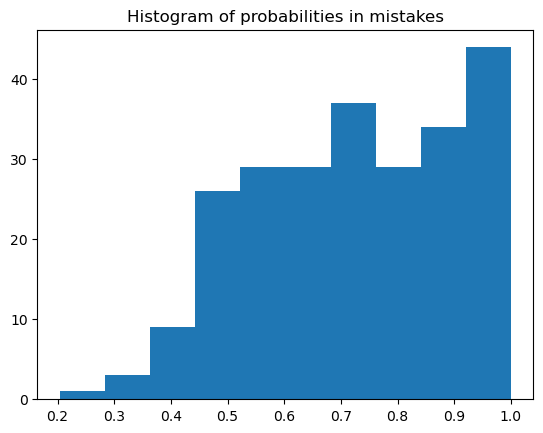

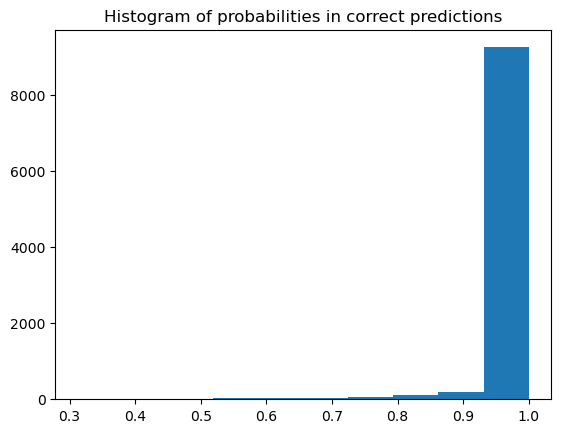

In [42]:
# see samples where the model is making most confident mistakes
mistakes = []
correct_predictions = []
all_predictions = probability_model(x_test).numpy()
for idx in range(x_test.shape[0]):
    actual_label = y_test[idx]
    predicted_label = np.argmax(all_predictions[idx])
    confidence = np.max(all_predictions[idx])
    if actual_label != predicted_label:
        mistakes.append((idx, actual_label, predicted_label, confidence))
    else:
        correct_predictions.append((idx, actual_label, predicted_label, confidence))

mistakes.sort(key=lambda x: x[3], reverse=True)
# show histogram of probabilities in mistakes v/s correct predictions
print ("Number of mistakes: ", len(mistakes))
print ("Number of correct predictions: ", len(correct_predictions))

mistakes = np.array(mistakes)
correct_predictions = np.array(correct_predictions)
plt.hist(mistakes[:, 3], bins=10)
plt.title("Histogram of probabilities in mistakes")
plt.show()

plt.hist(correct_predictions[:, 3], bins=10)
plt.title("Histogram of probabilities in correct predictions")
plt.show()

241  mistakes
Top 5 mistakes
Actual label:  6.0
Predicted label:  4.0  with confidence:  0.9998944997787476


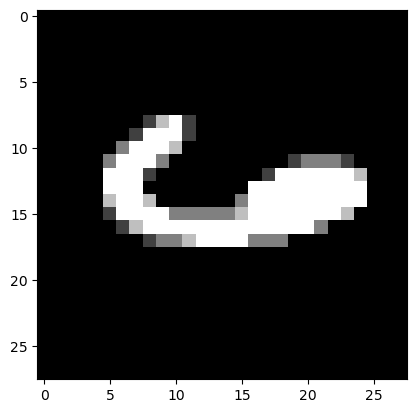

Actual label:  4.0
Predicted label:  6.0  with confidence:  0.9992710947990417


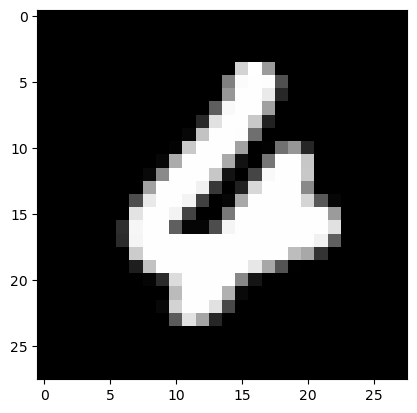

Actual label:  6.0
Predicted label:  1.0  with confidence:  0.998816967010498


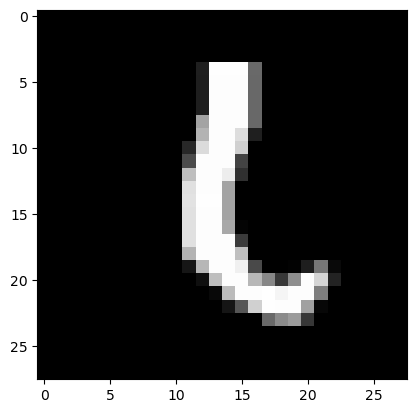

Actual label:  9.0
Predicted label:  4.0  with confidence:  0.998257577419281


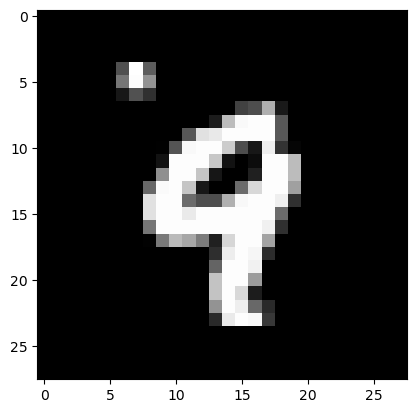

Actual label:  1.0
Predicted label:  6.0  with confidence:  0.9944276809692383


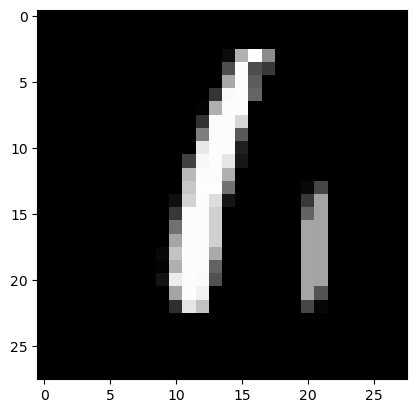

In [46]:
print (len(mistakes), " mistakes")
print ("Top 5 mistakes")
for idx, actual_label, predicted_label, confidence in mistakes[:5].tolist():
    print ("Actual label: ", actual_label)
    print ("Predicted label: ", predicted_label, " with confidence: ", confidence)
    plt.imshow(x_test[int(idx)], cmap='gray')
    plt.show()